# Notebook Overview

This notebook intends to provide the full workflow of the sentiment analysis task provided. The notebook also acts as a theoretical supplement to the higher level rapport, where we will dive deeper into the mathematical and conceptual defintions of the techniques with further analysis.  



# Necessities <a class="anchor" id="necessities"></a>

## Imports <a class="anchor" id="imports"></a>

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
import numpy as np
from itertools import permutations
import re
import string
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import binarize
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import LinearSVC
from sklearn.metrics import cohen_kappa_score
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
from nltk import agreement



## Reading the Data <a class="anchor" id="readingdata"></a>

In [ ]:
# read crowdsourced data
crowdsourced_train_df = pd.read_csv("crowdsourced_train.csv", sep="\t", encoding="utf-8")

# read gold data
gold_train_df = pd.read_csv("gold_train.csv", sep="\t", encoding="utf-8")

# read test data
test_df = pd.read_csv("test.csv", sep="\t", encoding="utf-8")

# show first 5 rows for each dataset
print("Crowdsourced Training Dataset:")
print(crowdsourced_train_df.head())

print("\nGold Training Dataset:")
print(gold_train_df.head())

print("\nTest Dataset:")
print(test_df.head())

Crowdsourced Training Dataset:
  sentiment                                               text
0  Positive  There's so much misconception on Islam rn so s...
1  Positive  @Mr_Rondeau You should try Iron Maiden at abou...
2  Negative  Going to #FantasticFour tomorrow. Half expecti...
3   Neutral  @cfelan hey hey, just checkng to see if you or...
4  Positive  does anyone just get drunk and watch twilight ...

Gold Training Dataset:
  sentiment                                               text
0   neutral  There's so much misconception on Islam rn so s...
1   neutral  @Mr_Rondeau You should try Iron Maiden at abou...
2   neutral  Going to #FantasticFour tomorrow. Half expecti...
3   neutral  @cfelan hey hey, just checkng to see if you or...
4   neutral  does anyone just get drunk and watch twilight ...

Test Dataset:
  sentiment                                               text
0   neutral  Niall will follow me One Day  That day just is...
1  negative  always pull the gay card cause some

# Data & Feature Engineering <a class="anchor" id="featureeng"></a>

Before performing any sort of EDA, we want to clean both our labels and text columns. The first step being label cleaning, which is due to us desiring unison in the categories and for example no misspellings such as "X008_nedative", which believe it or not is in fact present. If we do not clean our labels, we will not be able to investigate the class distribution and will most importantly be unable to fit a model and eventually predict values. The latter step of cleaning the text (commonly known as cleaning the corpus), is also an important step, as the goal for EDA and model fitting is to find patterns that can be utilized to predict future values. It is therefore important to filter out noise such as stopwords, which may appear a lot for a certain sentiment, but doesn't have any value in regards to an underlying pattern.

## Label Cleaning <a class="anchor" id="labelcleaning"></a>

We start by checking if there are any missing values in the data set.

In [ ]:
# print a table of missing values amount and percentage
def print_missing_values(df, name):
    missing_values = df.isnull().sum()
    total_values = df.shape[0]
    print(f"\n{name} Dataset Missing Values:")
    # cosmetics
    print(f"{'Column Name':<20}{'Missing Values':<20}{'Percentage':<20}")
    print("-" * 60)
    for column, missing in missing_values.items():
        percentage = (missing / total_values) * 100
        print(f"{column:<20}{str(missing):<20}{percentage:.2f}%".rjust(20))
    print("\n")

# print for each dataset
print_missing_values(crowdsourced_train_df, "Crowdsourced Train")
print_missing_values(gold_train_df, "Gold Train")
print_missing_values(test_df, "Test")


Crowdsourced Train Dataset Missing Values:
Column Name         Missing Values      Percentage          
------------------------------------------------------------
sentiment           0                   0.00%
text                0                   0.00%



Gold Train Dataset Missing Values:
Column Name         Missing Values      Percentage          
------------------------------------------------------------
sentiment           0                   0.00%
text                0                   0.00%



Test Dataset Missing Values:
Column Name         Missing Values      Percentage          
------------------------------------------------------------
sentiment           0                   0.00%
text                0                   0.00%




Now we need to check if any labels (sentiments) are blank strings and not just NaN. 

**Note**: This means a label could just be: "" or "  " or some other larger blank string.

In [ ]:
# print table showing amount and percentage of labels that contain blanks
def print_blank_spaces(df, name):
    blank_spaces_count = (df.apply(lambda x: x.str.isspace())).sum()
    total_values = df.shape[0]
    # same cosmetics as the prior function
    print(f"\n{name} Dataset Blank Spaces Count:")
    print(f"{'Column Name':<20}{'Blank Spaces Count':<20}{'Percentage':<20}")
    print("-" * 60)
    for column, count in blank_spaces_count.items():
        percentage = (count / total_values) * 100
        print(f"{column:<20}{str(count):<20}{percentage:.2f}%".rjust(20))
    print("\n")

# print for each dataset
print_blank_spaces(crowdsourced_train_df, "Crowdsourced Train")
print_blank_spaces(gold_train_df, "Gold Train")
print_blank_spaces(test_df, "Test")


Crowdsourced Train Dataset Blank Spaces Count:
Column Name         Blank Spaces Count  Percentage          
------------------------------------------------------------
sentiment           0                   0.00%
text                0                   0.00%



Gold Train Dataset Blank Spaces Count:
Column Name         Blank Spaces Count  Percentage          
------------------------------------------------------------
sentiment           0                   0.00%
text                0                   0.00%



Test Dataset Blank Spaces Count:
Column Name         Blank Spaces Count  Percentage          
------------------------------------------------------------
sentiment           0                   0.00%
text                0                   0.00%




We can also see that there are no blank spaces, which is a special case we need to and have now considered.

Now that we have checked for the more glaring errors in regards to the annotations, we now turn to the problem of vocabulary errors which can be more intricate. While there only exists a small amount of incorrect labels, we deemed it better to create a generalized function and workflow that works for any finite amount of incorrectly provided labels, no matter the labels we use. This both increases our understanding of the inherent nature of the data and a generalized solution is generally more desired. The only true tradeoff here is time needed and spent coming up with and implementing such a solution. In this case the solution didn't take too long and was deemed a reasonable tradeoff.

The main goal is to retrieve every possible error that can occur and check if such an error exists in the label and change it to the correct label.

In order to solve this we start by defining a function that finds all permutations of a given word/string. We can observe that permuations are merely misspellings of a words assuming that the word contains all of the correct letters. Since we only have three words which differ greatly. This meaning, no matter the permuation/misspelling of the word "neutral", the misspelling will still be extremely different to a misspelling of the word "positive". 

While the *get_permutation* function aids in the label cleaning, we are resticting ourselves by relying on the aforementioned assumption regarding all letters of the lable being present. We therefore need another function that can handle such cases, which is discussed below.

In [ ]:
def get_permutations(string):
    """
    Method: generate all permutations of a given string.
    
    Input:
    string (str): The input string.
    
    Output:
    perms (list/array): A list containing all permutations of the input string.
    """
    # Generate permutations and convert them to a list
    perms = [''.join(p) for p in permutations(string)]
    return perms

# Example usage:
string = "positive"
print(get_permutations(string))


['positive', 'positiev', 'positvie', 'positvei', 'positeiv', 'positevi', 'posiitve', 'posiitev', 'posiivte', 'posiivet', 'posiietv', 'posiievt', 'posivtie', 'posivtei', 'posivite', 'posiviet', 'posiveti', 'posiveit', 'posietiv', 'posietvi', 'posieitv', 'posieivt', 'posievti', 'posievit', 'postiive', 'postiiev', 'postivie', 'postivei', 'postieiv', 'postievi', 'postiive', 'postiiev', 'postivie', 'postivei', 'postieiv', 'postievi', 'postviie', 'postviei', 'postviie', 'postviei', 'postveii', 'postveii', 'posteiiv', 'posteivi', 'posteiiv', 'posteivi', 'postevii', 'postevii', 'posiitve', 'posiitev', 'posiivte', 'posiivet', 'posiietv', 'posiievt', 'positive', 'positiev', 'positvie', 'positvei', 'positeiv', 'positevi', 'posivite', 'posiviet', 'posivtie', 'posivtei', 'posiveit', 'posiveti', 'posieitv', 'posieivt', 'posietiv', 'posietvi', 'posievit', 'posievti', 'posvitie', 'posvitei', 'posviite', 'posviiet', 'posvieti', 'posvieit', 'posvtiie', 'posvtiei', 'posvtiie', 'posvtiei', 'posvteii', 'po

Now that we can create a list/bag-of-words that have all of the misspellings of the labels, we can create a parser that returns the correct label.

The function *create_n_grams* eleviates the previously mentioned restriction of *get_permutations* by using a sliding window going back and forth creating n-grams for each substring in the window. The window (substring) is important here since normal n-grams will only provide the example below restricting us again as we also want to find different misspellings for **all** substrings of the label.
p
po,
pos,
posi,
posit,
positi,
positiv,
positive.

The main goal of the *create_n_grams* function is to later be able to sift through the resulting list and find **all** permutation/misspelling cases for **all** substrings of a label, and therfore the label as a whole.

In [ ]:
def create_n_grams(label: str) -> list:
    lst_of_n_grams = list()
    for i in range(3,len(label)+1):
        lst_of_n_grams.append(label[0:i])
    return lst_of_n_grams
lst = create_n_grams("Positive")
for item in lst:
    print(get_permutations(item))


['Pos', 'Pso', 'oPs', 'osP', 'sPo', 'soP']
['Posi', 'Pois', 'Psoi', 'Psio', 'Pios', 'Piso', 'oPsi', 'oPis', 'osPi', 'osiP', 'oiPs', 'oisP', 'sPoi', 'sPio', 'soPi', 'soiP', 'siPo', 'sioP', 'iPos', 'iPso', 'ioPs', 'iosP', 'isPo', 'isoP']
['Posit', 'Posti', 'Poist', 'Poits', 'Potsi', 'Potis', 'Psoit', 'Psoti', 'Psiot', 'Psito', 'Pstoi', 'Pstio', 'Piost', 'Piots', 'Pisot', 'Pisto', 'Pitos', 'Pitso', 'Ptosi', 'Ptois', 'Ptsoi', 'Ptsio', 'Ptios', 'Ptiso', 'oPsit', 'oPsti', 'oPist', 'oPits', 'oPtsi', 'oPtis', 'osPit', 'osPti', 'osiPt', 'ositP', 'ostPi', 'ostiP', 'oiPst', 'oiPts', 'oisPt', 'oistP', 'oitPs', 'oitsP', 'otPsi', 'otPis', 'otsPi', 'otsiP', 'otiPs', 'otisP', 'sPoit', 'sPoti', 'sPiot', 'sPito', 'sPtoi', 'sPtio', 'soPit', 'soPti', 'soiPt', 'soitP', 'sotPi', 'sotiP', 'siPot', 'siPto', 'sioPt', 'siotP', 'sitPo', 'sitoP', 'stPoi', 'stPio', 'stoPi', 'stoiP', 'stiPo', 'stioP', 'iPost', 'iPots', 'iPsot', 'iPsto', 'iPtos', 'iPtso', 'ioPst', 'ioPts', 'iosPt', 'iostP', 'iotPs', 'iotsP', 'isPot'

While the implementation of *create_n_grams* is a general solution, we can observe how the only similarity between the labels is that the words "negative" and "positive" share the substring "tive". Thus, if we can get rid of and even skip these permutations, we are clear of any risk of incorrectly relabelling.

In [ ]:
def create_n_grams(label: str) -> list:
    lst_of_n_grams = list()
    for i in range(3, len(label) + 1):
        for j in range(len(label) - i + 1):
            n_gram = label[j:j+i]
            if "tive" not in n_gram:
                lst_of_n_grams.append(n_gram)
    return lst_of_n_grams

In [ ]:
def exclude_words_n_gram(n_grams: list) -> list:
    lst = create_n_grams("tive")
    permut = list()
    for gram in lst:
        lst_of_permutations = get_permutations(gram)
        for item in lst_of_permutations:
            permut.append(item)

    return [perm for perm in n_grams if perm not in permut]


We include special characters since we have labels with "_".

In [ ]:
def clean_special_characters(sentiment):
    """
    Method: remove special characters, spaces, and other unwanted characters from the sentiment label.
    
    Input:
    sentiment (str): The sentiment label to be cleaned.
    
    Output:
    str: cleaned sentiment label.
    """
    cleaned_sentiment = ''.join(letter for letter in sentiment if letter.isalnum())
    
    return cleaned_sentiment

In [ ]:

'''
def create_n_grams(label: str) -> list:
    lst_of_n_grams = list()
    counter = 0
    for i in range(3, len(label) + 1):
        lst_of_n_grams.append(label[0:i])
        lst_of_n_grams.append(label[counter + 1:i])
    return lst_of_n_grams
'''

def clean_sentiment_labels(sentiment):
    """
    Method: clean and correct sentiment labels in a dataset.
    
    Input:
    sentiment (str): The sentiment label to be cleaned.
    
    Output:
    str: The cleaned sentiment label.
    """
    # create n grams
    positive_n_grams = create_n_grams("positive")
    positive_n_grams = exclude_words_n_gram(positive_n_grams)
    negative_n_grams = create_n_grams("negative")
    negative_n_grams = exclude_words_n_gram(negative_n_grams)
    neutral_n_grams = create_n_grams("neutral")
    
    # set data structure to make sure that we do not get any duplicate permutations.
    permutations_of_positive = set()
    permutations_of_negative = set()
    permutations_of_neutral = set()
    
    # iterate over all possible errors
    for positive_word, negative_word, neutral_word in zip(positive_n_grams, negative_n_grams, neutral_n_grams):
        permutations_of_positive.update(get_permutations(positive_word))
        permutations_of_negative.update(get_permutations(negative_word))
        permutations_of_neutral.update(get_permutations(neutral_word))
    
    # clean sentiment of any spaces, special characters
    cleaned_sentiment = clean_special_characters(sentiment)
    
    # convert to lowercase and remove leading/trailing whitespaces
    sentiment_lower = cleaned_sentiment.lower().strip()
    
    # check if cleaned sentiment matches any permutations of "positive", "negative", or "neutral"
    positive_found = any(permutation.lower() in sentiment_lower for permutation in permutations_of_positive)
    negative_found = any(permutation.lower() in sentiment_lower for permutation in permutations_of_negative)
    neutral_found = any(permutation.lower() in sentiment_lower for permutation in permutations_of_neutral)
    
    # if not sure about label return "Mixed"
    if positive_found and negative_found:
        return "Mixed"
    elif positive_found and neutral_found:
        return "Mixed"
    elif negative_found and neutral_found:
        return "Mixed"
    
    # else --> check if cleaned sentiment matches any single permutation
    if positive_found:
        return "positive"
    elif negative_found:
        return "negative"
    elif neutral_found:
        return "neutral"

    # if no match found, return the original label
    return cleaned_sentiment.capitalize()

# quick test
sentiment_label = "x008_neg"
cleaned_label = clean_sentiment_labels(sentiment_label)
print(cleaned_label)  # Output: Neutral

# another quicks test
sentiment_label = "nedative"
cleaned_label = clean_sentiment_labels(sentiment_label)
print(cleaned_label)  # Output: Neutral


negative
negative


In [ ]:


def print_unique_sentiments(df: pd.DataFrame, name: string) -> None:
    '''
    Method: print all unique labels for the chosen sentiment (name)
    Input: df: pd.DataFrame, name: string
    Output: None
    '''
    unique_sentiments = df['sentiment'].unique()
    num_unique_labels = len(unique_sentiments)
    print(f"\n{name} Dataset:")
    print(f"Number of unique labels: {num_unique_labels}")
    print("Unique sentiments:")
    for sentiment in unique_sentiments:
        print(sentiment)

# results for each dataset
print_unique_sentiments(crowdsourced_train_df, "Crowdsourced Train")



Crowdsourced Train Dataset:
Number of unique labels: 37
Unique sentiments:
Positive
Negative
Neutral
neutral
negative
positive
neutral?
Nuetral
negative 
positive 
neutral 
 negative
Nedative
_x0008_neutral
netural
netutral
Neutral 
Neural
Neutrall
Netural
neugral
neutrla
negtaive
postive
                neutral
                                        positive
    positive
 neutral
               negative
Nutral
negayive
positie
neutra l
npositive
neutal
postitive
Positve


The code and resulting output above shows all of the unique labels that are in the crowdsourced dataset. We can see a few extreme cases of bad annotation such as "_x008_neutral".

In [ ]:
def clean_crowdsourced_labels(df: pd.DataFrame) -> pd.DataFrame:
    """
    Overview:
    Method: clean sentiment labels in a generic dataset.
    
    Input:
    df: pd.DataFrame: The crowdsourced dataset DataFrame.
    positive_permutations (list): List of permutations of the "positive" label.
    negative_permutations (list): List of permutations of the "negative" label.
    neutral_permutations (list): List of permutations of the "neutral" label.
    
    Output:
    df: pd.DataFrame: The cleaned crowdsourced dataset DataFrame.
    """
    df['sentiment'] = df['sentiment'].apply(lambda x: clean_sentiment_labels(x))
    return df

# clean sentiment labels
cleaned_crowdsourced_train_df = clean_crowdsourced_labels(crowdsourced_train_df)

In [ ]:
print_unique_sentiments(crowdsourced_train_df, "Crowdsourced Train")


Crowdsourced Train Dataset:
Number of unique labels: 3
Unique sentiments:
positive
negative
neutral


We can see that we now only have the desired labels, and are therefore finished with cleaning the labels. The next stage of our workflow is to clean the corpus and then perform Explorative Data Analysis (EDA). This means that we want to look at how the data behaves statistically, whether this being distributions of labels, or checking for imbalances and bias by showing insightful data visualizations. 

We begin EDA by checking for any bias and imbalances.

### Cleaning the Corpus <a class="anchor" id="textcleaning"></a>

In order to capture the picture and optimize pattern recognition, elimination of redudant data that can lead our model down the wrong path when fitting is essential. We therefore want to eliminate words or characters that may occurs, especially frequently, that do not provide information about the sentiment. This meaning that the word "the" may occur frequently, so when we fit a Multinomial model to the text data, the model will count "the" as a pattern for that sentiment. This is however not the case as such a word is used no matter the context or sentiment, which brings us to the first type of words or characters that need to filtered out, namely Stopwords. Stopwords are words that are commonly used in the English language. Such examples of words are "and", "the" and "a" etc.

After that we eliminate any punctuation, links, mentions etc. storing the final cleaned text for each dataset in its own column for later comparison between the non-cleaned dataset.

To summarise, we want to clean the text since our goal is to predict the sentiment given the words in the text and not based on the format of the text/tweet.

**Note** <br>
It is important to note that we also clean the test data. This is due to that the steps below can be carried out when given unseen data once the model is deployed, since the cleaning is part of our machine learning pipeline. 

In [ ]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stopwords.words('english')])

crowdsourced_train_df['cleaned_text'] = crowdsourced_train_df['text'].apply(lambda text: cleaning_stopwords(text))
gold_train_df['cleaned_text'] = gold_train_df['text'].apply(lambda text:cleaning_stopwords(text))
test_df['cleaned_text'] = test_df['text'].apply(lambda text: cleaning_stopwords(text))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
import string
#Remove punctuations, links, mentions and \r\n new line characters
#def strip_all_entities(text): 
#    #text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
#    #text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
#    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
#    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
#    return text

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

crowdsourced_train_df['cleaned_text'] = crowdsourced_train_df['cleaned_text'].apply(clean_text)
crowdsourced_train_df['cleaned_text'] = crowdsourced_train_df['cleaned_text'].apply(clean_hashtags)
crowdsourced_train_df['cleaned_text'] = crowdsourced_train_df['cleaned_text'].apply(filter_chars)
crowdsourced_train_df['cleaned_text'] = crowdsourced_train_df['cleaned_text'].apply(remove_mult_spaces)

# Apply the functions to create new columns for cleaned data in gold_train_df
gold_train_df['cleaned_text'] = gold_train_df['cleaned_text'].apply(clean_text)
gold_train_df['cleaned_text'] = gold_train_df['cleaned_text'].apply(clean_hashtags)
gold_train_df['cleaned_text'] = gold_train_df['cleaned_text'].apply(filter_chars)
gold_train_df['cleaned_text'] = gold_train_df['cleaned_text'].apply(remove_mult_spaces)

test_df['cleaned_text'] = test_df['cleaned_text'].apply(clean_text)
test_df['cleaned_text'] = test_df['cleaned_text'].apply(clean_hashtags)
test_df['cleaned_text'] = test_df['cleaned_text'].apply(filter_chars)
test_df['cleaned_text'] = test_df['cleaned_text'].apply(remove_mult_spaces)

# EDA <a class="anchor" id="EDA"></a>

Now that we have cleaned the corpus and labels, it is high time to perform explorative data analysis (EDA). This means that we want to investigate everything from potential risks that our data poses to underlying patterns in the data that can be utilized when modelling. In this section we begin by looking at Bias and Imbalances. 

### Checking for Bias and Imbalances <a class="anchor" id="biasimbalance"></a>
We begin by providing a short description of what bias and imbalance are and how they can occur in our situation.

**Bias in Data** <br>
In the context of data, bias refers to the presence of systematic errors or distortions in the data collection process that may lead to inaccurate or skewed representations of the underlying population or phenomenon. Data bias can arise from various sources, including sampling methods, measurement errors, selection bias, or cultural and societal factors.

In our situation there may exist a bias in the labelling, since one annotator may support a certain political party or football team, thus annotating any news that is positive for those parties or teams as positive, while a different annotator has different beliefs resulting in a discrepancy in labelling. Also we note that the crowdsourced data has more than two raters/annotators, but they only label a subset of the sample. This could also be improved by making every annotator label all texts, enabling us to use the Fleiss' Kappa score which fits our certain scenario better than the Cohen Kappa, leading to a more reliable score in regards to similarity between the labels. Enforcing such a labelling methodology essentialy creates more label data points to investigate bias.

**Imbalance in Data** <br>
Data imbalance occurs when the distribution of classes or categories within a dataset is heavily skewed, with one class significantly outnumbering the others. Imbalanced data can pose challenges for machine learning algorithms, particularly in classification tasks, where the model may be biased towards the majority class and perform poorly on the minority class.

In our situation we may have more "neutral" labels than "positive" in our training set, leading to difficulty in predicting any positive test data. This is a serious risk we need to take into consideration before deploying a model, since we need the model to be reliable on all labels. To eleviate such problems we can use stratified-, under- or oversampling.

Under sampling deletes instances from the overrepresented label at random. Deleting instances in this manner can however lead to deleting potentially informative texts. Instead of undersampling, one can turn to oversampling. Over sampling picks data with replacement and makes copies of the instances from the underrepresented label. Oversampling also has the risk of mostly choosing uninformative texts, leading to a worse overall performance. 

In [ ]:

# Function to print label distribution
def print_label_distribution(df, name):
    label_counts = df['sentiment'].value_counts()
    total_values = df.shape[0]
    print(f"\n{name} Dataset Label Distribution:")
    print(f"{'Sentiment':<10}{'Count':<10}{'Percentage':<20}")
    print("-" * 40)
    for label, count in label_counts.items():
        percentage = (count / total_values) * 100
        print(f"{label:<10}{str(count):<10}{percentage:.2f}%".rjust(10))
    print("\n")

# Print label distribution for each dataset
print_label_distribution(crowdsourced_train_df, "Crowdsourced Train")
print_label_distribution(gold_train_df, "Gold Train")
print_label_distribution(test_df, "Test")


Crowdsourced Train Dataset Label Distribution:
Sentiment Count     Percentage          
----------------------------------------
neutral   5079      47.57%
positive  3219      30.15%
negative  2378      22.27%



Gold Train Dataset Label Distribution:
Sentiment Count     Percentage          
----------------------------------------
neutral   5364      50.24%
positive  3652      34.21%
negative  1660      15.55%



Test Dataset Label Distribution:
Sentiment Count     Percentage          
----------------------------------------
neutral   2597      47.01%
positive  1850      33.49%
negative  1077      19.50%




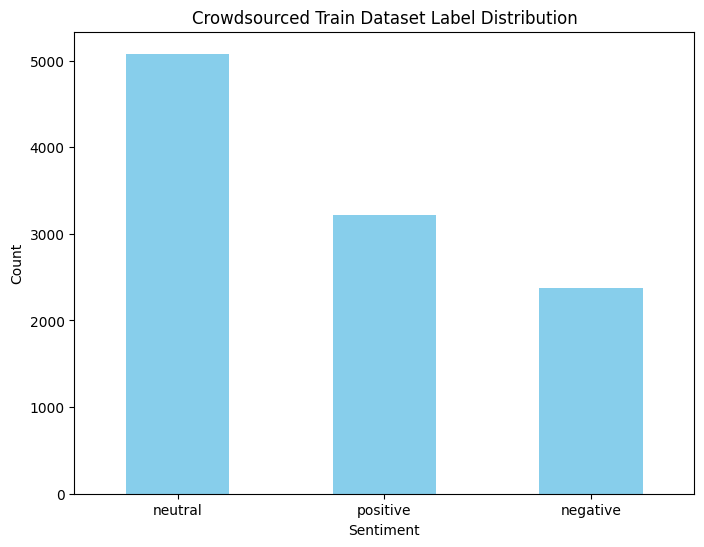

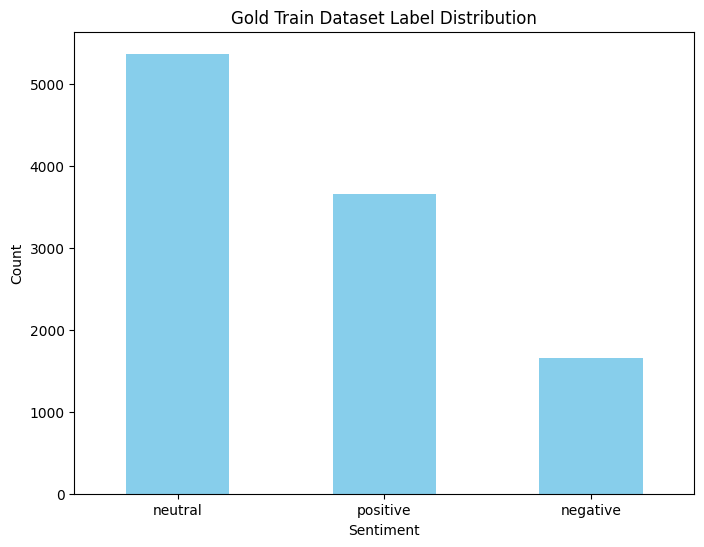

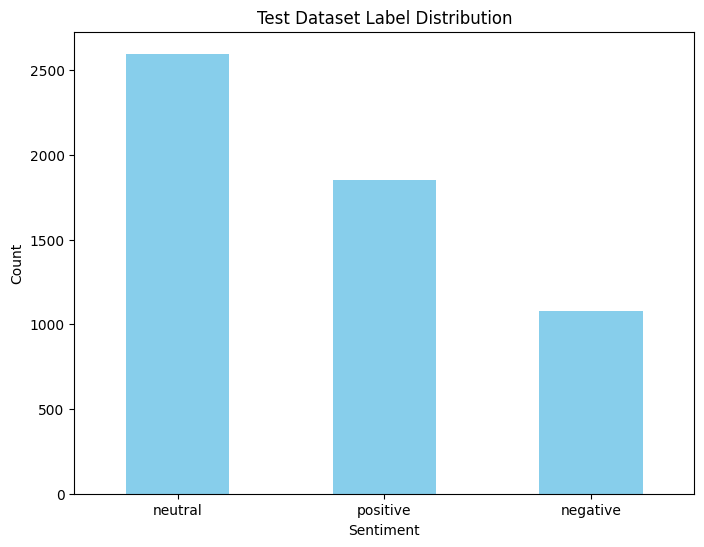

In [ ]:
# Function to plot label distribution
def plot_label_distribution(df, name):
    label_counts = df['sentiment'].value_counts()
    plt.figure(figsize=(8, 6))
    label_counts.plot(kind='bar', color='skyblue')
    plt.title(f"{name} Dataset Label Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.xticks(rotation=0)
    plt.show()

# Plot label distribution for each dataset
plot_label_distribution(crowdsourced_train_df, "Crowdsourced Train")
plot_label_distribution(gold_train_df, "Gold Train")
plot_label_distribution(test_df, "Test")

In [ ]:
temp_crowd = crowdsourced_train_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp_gold = gold_train_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp_test = test_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text', ascending = False)

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp_crowd.sentiment,
    values = temp_crowd.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution for Crowdsourced Data"}
    ))
fig.show()

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp_gold.sentiment,
    values = temp_gold.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution for Golden Data"}
    ))

fig.show()

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp_test.sentiment,
    values = temp_test.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution for Text Data"}
    ))

fig.show()

From the above we can see that we have rather similar label distribution for all datasets. We can however observe that the distribution between sentiments for all sets, especially training sets are not equally distributed. This gives cause to believe that our models run the risk of having lower recall, precision and accuracy for negative and positive sentiments. This is rather alarming since a large goal of sentiment analysis is to be able to predict whether a text is positive or negative. This means that a large amount of applications within this domain prioritize high recall for positive and negative sentiments. 

There are various approaches we can take to create an evenly distributed data set. One such approach is by oversampling by creating new data by drawing preexisting data entries with replacement. This will be investigated later on in the notebook.

When we have multiple annotators, we are running the risk of obtaining discprepancies in the labels. This is visible in our case from the figures above, where there are larger amount of neutral sentiments in the Golden data. Label discrepancy is undesirable, leading us to the next investigation we want to undergo, being a similarity test for the labels.

## Investigating Label similarity with Cohen's Kappa- & Gwert's AC1 score<a class="anchor" id="cohen"></a>

Before proceeding with the defintion of the Cohen Kappa score, we first need to check that our problem fulfills the prerequisites for the Cohen Kappa or if we should use the Fleiss' Kappa.

We note that we inherently have more than two raters which implies that we should use Fleiss' kappa. However our data doesn't show the different raters labels, where we only have one column for the labels. In order to use the Fleiss' score we need one column for each rater. This means that we consider the crowdsourced labels as one rater and the golden dataset as another, implying that we should use the Cohen Kappa score as we only have two raters. This is an assumption that was checked with the assignment coordinater and deemed to be correct. We note however that the best scenario would be to only have two different annotators, or that we enforce every annotator to labels all texts, so that we have a row for each annotator. 

Now that have provided the assumptions made we can now begin using the Cohen Kappa score.

**Definition**

Cohen's kappa evaluates the agreement between two raters beyond what would be expected by chance alone. It takes into account both the observed agreement $P_o$ and the expected agreement $P_e$ under random chance.  Cohen's kappa is calculated using,

$$
\kappa = \frac{{P_o - P_e}}{{1 - P_e}}
$$

Where $P_o$ is the observed proportion of agreement between the raters, and $P_e$ is the proportion of agreement expected by chance alone. The resulting score $\kappa \in [-1,1]$, where a score of 1 indicates perfect agreement between the raters, a score of 0 indicates agreement equal to that expected by chance alone, a score less than 0 indicates agreement worse than chance, and a score greater than 0 indicates agreement better than chance.
Both AC1 and Cohen’s Kappa measure agreement between two raters, but they differ in how they handle disagreement and the types of data they are suitable for. AC1 considers both positive and negative agreement, making it more suitable for multiclass classification tasks, while Cohen’s kappa focuses only on positive agreement and is commonly used for binary classification tasks. Given the problem conditions and constraints, the Gwert’s AC1 seems more appropriate. Upon investigation we obtain a Cohen’s Kappa score of 0.446, indicating moderate agreement, while we found a Gwert’s AC1 score of 0.6304, which is higher than the Cohen’s Kappa value we found, indicating substantial agreement between the two raters.

Below, we can see that we get the score of approximately 0.446. This score indicates a moderate agreement between the two raters. While the score suggests that there is agreement between the raters beyond what would be expected by chance alone, it is not close to a perfect score. 


In [ ]:
def ac1_score(labels1, labels2):
   
    total_pairs = 0
    agree_pairs = 0
    disagree_pairs = 0
    
    for i in range(len(labels1)):
        for j in range(i + 1, len(labels1)):
            if labels1[i] == labels1[j] and labels2[i] == labels2[j]:
                agree_pairs += 1
            elif labels1[i] != labels1[j] and labels2[i] != labels2[j]:
                agree_pairs += 1
            else:
                disagree_pairs += 1
            total_pairs += 1
    
    ac1 = agree_pairs / total_pairs
    return ac1

In [ ]:
kappa_score = cohen_kappa_score(crowdsourced_train_df['sentiment'], gold_train_df['sentiment'])
ac1_score_value = ac1_score(gold_train_df['sentiment'], crowdsourced_train_df['sentiment'])
print(f"AC1 score between crowdsourced and gold data: {ac1_score_value:.4f}")
print(f"Cohen's kappa score between crowdsourced and gold data: {kappa_score:.4f}")


AC1 score between crowdsourced and gold data: 0.6304
Cohen's kappa score between crowdsourced and gold data: 0.4463


### Exploring the diversity/variation in the language used in the different datasets

As mentioned we know that frequency of words plays a large roll when choosing a model. We therefore start by investigating the most common words for the cleaned data and "dirty" data.

#### Finding the top 20 occuring words for each dataset

In [ ]:
def get_top_words(df: pd.DataFrame, label: string, text_column: string):
    '''
    Method: get top words for a dataframe given a certain sentiment. This is only used in the print_top_most
    Input: 
    df: pd.DataFrame
    label: string

    Output: list
    '''
    cv = CountVectorizer()
    matrix = cv.fit_transform(df[df['sentiment'] == label][text_column])
    feature_names = cv.get_feature_names_out()
    word_freq = zip(feature_names, matrix.sum(axis=0).tolist()[0])
    return sorted(word_freq, key=lambda x: -x[1])[:20]


def print_top_most(df: pd.DataFrame, text_column) -> None:
    

    # store top words for each sentiment
    top_words_all = {
        'positive': [],
        'negative': [],
        'neutral': []
    }


    print(f"Dataset:")

    sentiment_labels = df['sentiment'].unique()
    max_sentiment_label_length = max(len(label) for label in sentiment_labels)
    print(f"Top 20 words used for Positive, Negative and Neutral sentiments:")
    for sentiment_label in sentiment_labels:
        top_words = get_top_words(df, sentiment_label, text_column)
        for word, freq in top_words:
            top_words_all[sentiment_label].append((word, freq))

    # print results in table
    print("{:<20} \n".format("Words:"), end="")
    for sentiment_label in top_words_all.keys():
        print("{:<40}".format(sentiment_label.capitalize()), end="")
    print()

    for i in range(20):
        for sentiment_label in top_words_all.keys():
            word, freq = top_words_all[sentiment_label][i]
            print("{:<25}".format(word), end="")
            print("{:<15}".format(freq), end="")
        print()
        
print_top_most(crowdsourced_train_df, 'cleaned_text')


Dataset:
Top 20 words used for Positive, Negative and Neutral sentiments:
Words:               
Positive                                Negative                                Neutral                                 
tomorrow                 576            may                      590            may                      800            
may                      454            tomorrow                 257            tomorrow                 633            
day                      410            like                     197            the                      360            
see                      297            im                       188            sunday                   328            
im                       284            the                      131            night                    327            
friday                   273            see                      128            day                      325            
the                      209            day              

In [ ]:
print_top_most(crowdsourced_train_df, 'text')

Dataset:
Top 20 words used for Positive, Negative and Neutral sentiments:
Words:               
Positive                                Negative                                Neutral                                 
the                      2634           the                      1891           the                      4341           
to                       1510           to                       1055           to                       2202           
and                      1075           and                      694            co                       1869           
in                       918            in                       684            in                       1644           
co                       903            is                       672            on                       1472           
on                       823            of                       624            and                      1295           
of                       788            may              

We can see from the resulting table, that many of the most common words are in all of the datasets. We can observe how a few of the most common words may not be great indicators to whether the text is positive, negative or neutral. Such a words could be https, which is present for all of the sentiment labels, and could just be a link to the source or redirecting the reader of the text to more resources regarding the provided information, which could be negative, positive or neutral. On the other hand, we can also see that the neutral sentiment has a considerable larger amount of links. The reason for this could be that the text is from a news outlet which most likely provides links to the actual article or are more strict with referencing sources. This can also be the case for negative and positive sentiments, where a user could be arguing their case and provides sources to back up their arguments. 

A more glaring example of words that may be misleading is the word "just" which is present for all sentiments. This word can be seen as a filler-word, and does not provide any sort of information regarding the sentiment. This needs to be taken into consideration when training our model, since machine learning models and algorithms at large cannot undergo such a rationale, which furhter shows how data cleaning and feature engineering is the most important part of the machine learning workflow/pipeline.

To further investigate this, we can look the gold_train_df, to see whether we have any similarities or differences between the results.

In [ ]:
print_top_most(gold_train_df, 'text')

Dataset:
Top 20 words used for Positive, Negative and Neutral sentiments:
Words:               
Positive                                Negative                                Neutral                                 
the                      2959           the                      1374           the                      4533           
to                       1773           to                       714            to                       2280           
and                      1140           in                       493            co                       1836           
co                       1040           is                       490            in                       1739           
in                       1014           and                      471            on                       1561           
on                       937            of                       461            and                      1453           
is                       929            may              

In [ ]:
print_top_most(gold_train_df, 'cleaned_text')

Dataset:
Top 20 words used for Positive, Negative and Neutral sentiments:
Words:               
Positive                                Negative                                Neutral                                 
tomorrow                 688            may                      447            may                      899            
day                      516            tomorrow                 142            tomorrow                 636            
may                      498            like                     127            the                      346            
see                      362            the                      100            friday                   305            
im                       338            im                       99             sunday                   304            
friday                   304            muslims                  86             night                    294            
night                    280            amp              

We can see that https and http are present for the test set, so it seems a good choice to consider them in the training sets. Otherwise we can see that quite a few words that are present in the test dataframe are not present in the training sets. This is good since we want to be able to test our model on such data, since the test sets purpose is to see how the model performs on unseen data, meaning no data leakage and datapoints that are unexpected. The more the variable the test data is the better understanding of our model we will get. We want to see how the model reacts to as extreme values and circumstances, since a deployed model should be anti-fragile in the sense that the model should be scalable and extreme value resitant. 

In [ ]:
def top_common_words_by_sentiment(df, text_column):
    sentiments = df['sentiment'].unique()
    top_words_by_sentiment = {}
    for sentiment in sentiments:
        top_words_df = pd.DataFrame(get_top_words(df, sentiment, text_column), columns=['word', 'count'])
        top_words_df['sentiment'] = sentiment
        top_words_by_sentiment[sentiment] = top_words_df
    return top_words_by_sentiment

crowdsourced_top_words_by_sentiment = top_common_words_by_sentiment(crowdsourced_train_df, 'cleaned_text')
gold_top_words_by_sentiment = top_common_words_by_sentiment(gold_train_df, 'cleaned_text')

for dataset_name, top_words_df in [('Crowdsourced Train', crowdsourced_top_words_by_sentiment), 
                                   ('Gold Train', gold_top_words_by_sentiment)]:
    for sentiment, top_words_df in top_words_df.items():
        fig = px.treemap(top_words_df.head(20), path=['word'], values='count', 
                         title=f'Top 20 Most Common Words for {sentiment.capitalize()} Sentiment - {dataset_name}')
        fig.show()

As seen from the above, we may want to get rid of words that frequently occurs for all sentiments (intersection of words between sentiment), as they do not provide further information. Examples of such words are: im and going. These are not considered to be common in the english vocabulary, so we need to manually exclude them. We manually exclude such words. These catches further exemplifies why EDA is critical for data science and machine learning. 

In [ ]:

def top_common_words(df: pd.DataFrame, name: str, text_column: str):
    '''
    Method: get top common words for a DataFrame.
    Input: 
    df: pd.DataFrame
    name: string
    text_column: string
    '''

    common_words = []
    for sentiment_label in ['positive', 'neutral', 'negative']:
        top_words = get_top_words(df, sentiment_label, text_column)
        common_words.extend([(word, count, name, sentiment_label) for word, count in top_words])
    return pd.DataFrame(common_words, columns=['Common_words', 'count', 'Dataset', 'Sentiment'])



common_words_crowdsourced = top_common_words(crowdsourced_train_df, 'Crowdsourced Train', 'cleaned_text')
common_words_gold = top_common_words(gold_train_df, 'Gold Train', 'cleaned_text')

#top common words for each dataset
crowdsourced_top_words = top_common_words(crowdsourced_train_df, 'Crowdsourced Train', 'cleaned_text')
gold_top_words = top_common_words(gold_train_df, 'Gold Train', 'cleaned_text')


In [ ]:
def top_common_words(df: pd.DataFrame, text_column: str):
    '''
    Method: get top common words for a DataFrame.
    Input: 
    df: pd.DataFrame
    name: string
    text_column: string
    '''
    # store list of all dictionaries 
    common_words = list()
   
    for sentiment_label in ['positive', 'neutral', 'negative']:
        top_words = get_top_words(df, sentiment_label, text_column)
        data = {
                    'word': list(dict(get_top_words(df, sentiment_label, text_column)).keys()),
                    'count': list(dict(get_top_words(df, sentiment_label,text_column)).values())

                }
        common_words.append(pd.DataFrame(data))

    common_words_df = common_words[0].copy()

    for dataframe in common_words[1:]:
        common_words_df = pd.merge(common_words_df, dataframe, on='word', how='inner', suffixes=('_1', '_2'))
        # Add the counts from both DataFrames
        common_words_df['count'] = common_words_df['count_1'] + common_words_df['count_2']
        # Drop the count columns from the merge
        common_words_df.drop(columns=['count_1', 'count_2'], inplace=True)
    
    return common_words_df[['word','count']]

top_common_words(crowdsourced_train_df, 'cleaned_text')

,word,count
0,tomorrow,1466
1,may,1844
2,day,860
3,see,679
4,im,710
5,friday,672
6,the,700
7,sunday,633
8,going,579
9,like,605


In [ ]:
def top_common_intersecting_words(df: pd.DataFrame, text_column: str):
    '''
    Method: get top common words for a DataFrame.
    Input: 
    df: pd.DataFrame
    name: string
    text_column: string
    '''
    # store list of all dictionaries 
    common_words = list()
   
    for sentiment_label in ['positive', 'neutral', 'negative']:
        top_words = get_top_words(df, sentiment_label, text_column)
        data = {
                    'word': list(dict(get_top_words(df, sentiment_label, text_column)).keys()),
                    'count': list(dict(get_top_words(df, sentiment_label,text_column)).values())

                }
        common_words.append(pd.DataFrame(data))

    common_words_df = common_words[0].copy()

    for dataframe in common_words[1:]:
        common_words_df = pd.merge(common_words_df, dataframe, on='word', how='inner', suffixes=('_1', '_2'))
        # add the counts from both DataFrames
        common_words_df['count'] = common_words_df['count_1'] + common_words_df['count_2']
        # drop the count columns from the merge
        common_words_df.drop(columns=['count_1', 'count_2'], inplace=True)
    
    return common_words_df[['word','count']].sort_values(by='count', ascending=False)



intersecting_top_words_crowdsourced = top_common_intersecting_words(crowdsourced_train_df,  'cleaned_text')
intersecting_top_words_gold = top_common_intersecting_words(gold_train_df,  'cleaned_text')


fig = px.bar(intersecting_top_words_crowdsourced, x='word', y='count', 
             title='Intersecting Top 20 Common Words in Crowdsourced Train Dataset', 
             color_discrete_sequence=px.colors.qualitative.Pastel)

fig.show()



In [ ]:
for dataset_name, intersecting_top_words_df in [('Crowdsourced Train', intersecting_top_words_crowdsourced), 
                                                ('Gold Train', intersecting_top_words_gold)]:
    fig = px.treemap(intersecting_top_words_df, path=['word'], values='count', 
                     title=f'Intersecting Top 20 Most Common Words - {dataset_name}')
    fig.show()

The resulting figures shows the words that coincide with the top 20 common words for all sentiments in the dataset. These words are therefore considered to be uninformative in regards to the sentiment since they occur in all labels. We therefore want to filter out these words.

We also note that since the labelling is not perfect, we will in turn get discrepencies in regards to the general patterns in the data. In this case we see a discprency in regards to the top 20 words for each sentiment and the intersection between the sentiments for the two datasets.

In [ ]:
for name, temp_df in [('Crowdsourced Train', common_words_crowdsourced), ('Gold Train', common_words_gold)]:
    fig = px.treemap(temp_df, path=['Common_words'], values='count', 
                     title=f'Tree of Most Common Words - {name}')
    fig.show()

In [ ]:
def top_common_words_by_sentiment(df, text_column):
    sentiments = df['sentiment'].unique()
    top_words_by_sentiment = {}
    for sentiment in sentiments:
        top_words_df = dict(get_top_words(df,sentiment, text_column))
        top_words_by_sentiment[sentiment] = top_words_df
    return top_words_by_sentiment

top_common_words_by_sentiment(crowdsourced_train_df,'cleaned_text');

Given the EDA above we extract the intersection top words and create a bag-of-words for each dataset respectively and filter them out. 

In [ ]:
intersecting_top_words_crowdsourced = top_common_intersecting_words(crowdsourced_train_df,  'cleaned_text')['word']
intersecting_top_words_gold = top_common_intersecting_words(gold_train_df,  'cleaned_text')['word']

def cleaning_crowd_bag(text):
    return " ".join([word for word in str(text).split() if word not in list(intersecting_top_words_crowdsourced)])

def cleaning_gold_bag(text):
    return " ".join([word for word in str(text).split() if word not in list(intersecting_top_words_gold)])

crowdsourced_train_df['cleaned_text'] = crowdsourced_train_df['cleaned_text'].apply(lambda text: cleaning_crowd_bag(text))
gold_train_df['cleaned_text'] = gold_train_df['cleaned_text'].apply(lambda text:cleaning_gold_bag(text))

As we can see there are some frequently occuring words that we deem to provide no information regarding the sentiment. Such an example is the word "I" or the subtext "-". The latter example is not even a word, therefore providing no insight into a texts sentiment. We should however be cautious with subtexts, as for example "https" may provide insight, as it may more likely be a news outlet referencing a certain article. With this in mind, we may only want to clean special characters and not bag of words which are commonly used in the NLP realm.

### Unique words

Before considering cleaning the corpus, we want to investigate the unique words for each sentiment. Such words could provide insights regarding patterns. Data Science and machine learning is essentially pattern recognition, so this seems apropriate.

In [ ]:
# combine/concatinate all datasets
from collections import Counter
combined_df = pd.concat([crowdsourced_train_df, gold_train_df])

# get unique words
def top_unique_words_by_sentiment_combined(df):
    sentiments = df['sentiment'].unique()
    top_unique_words_by_sentiment = {}
    for sentiment in sentiments:
        sentiment_df = df[df['sentiment'] == sentiment]
        all_words = ' '.join(sentiment_df['text']).split()
        word_counts = Counter(all_words)
        # before cleaning we want to filter out any special chars
        top_unique_words = [(word, count) for word, count in word_counts.items() if word.isalpha()]
        top_unique_words_sorted = sorted(top_unique_words, key=lambda x: x[1], reverse=True)[:20]
        top_unique_words_df = pd.DataFrame(top_unique_words_sorted, columns=['Common_words', 'count'])
        top_unique_words_df['Sentiment'] = sentiment
        top_unique_words_by_sentiment[sentiment] = top_unique_words_df
    return top_unique_words_by_sentiment


top_unique_words_by_sentiment_combined = top_unique_words_by_sentiment_combined(combined_df)

for sentiment, top_unique_words in top_unique_words_by_sentiment_combined.items():
    print(f"Top unique words for {sentiment.capitalize()} sentiment:")
    print(top_unique_words[:20])  # Display top 20 unique words
    print()

Top unique words for Positive sentiment:
   Common_words  count Sentiment
0           the   5120  positive
1            to   3198  positive
2           and   2048  positive
3             I   1994  positive
4             a   1988  positive
5            in   1835  positive
6            on   1651  positive
7            of   1619  positive
8            is   1575  positive
9           for   1514  positive
10         with   1125  positive
11          you   1091  positive
12           be   1039  positive
13           my    825  positive
14           at    814  positive
15           it    744  positive
16          may    738  positive
17     tomorrow    711  positive
18         have    589  positive
19          see    586  positive

Top unique words for Negative sentiment:
   Common_words  count Sentiment
0           the   3024  negative
1            to   1720  negative
2             a   1282  negative
3             I   1153  negative
4            is   1102  negative
5            in   1099  ne

In [ ]:
for sentiment, df in top_unique_words_by_sentiment_combined.items():
    fig = px.treemap(df, path=['Common_words'], values='count',
                     title=f'Top Unique Words for {sentiment.capitalize()} Sentiment - All Training Data concatinated')
    fig.show()

In [ ]:
for sentiment, df in top_unique_words_by_sentiment_combined.items():
    fig = px.pie(df, names='Common_words', values='count',
                 title=f'Top Unique Words for {sentiment.capitalize()} Sentiment - All Datasets Combined',
                 hole=0.4)
    fig.show()

In [ ]:
!pip install WordCloud==1.9.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.6/513.6 kB 42.8 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


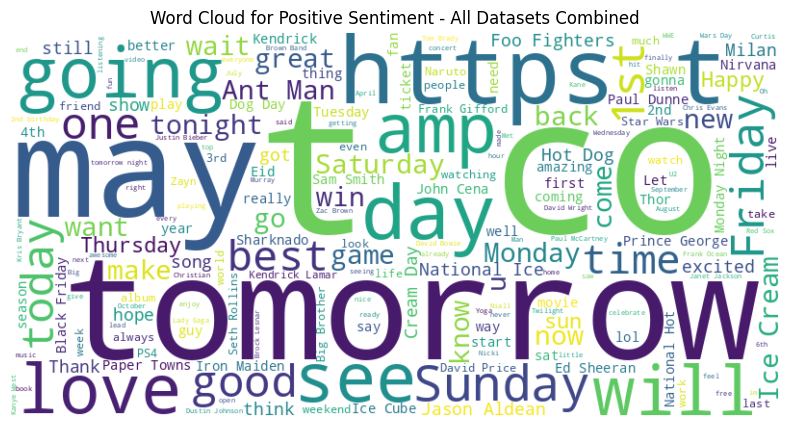

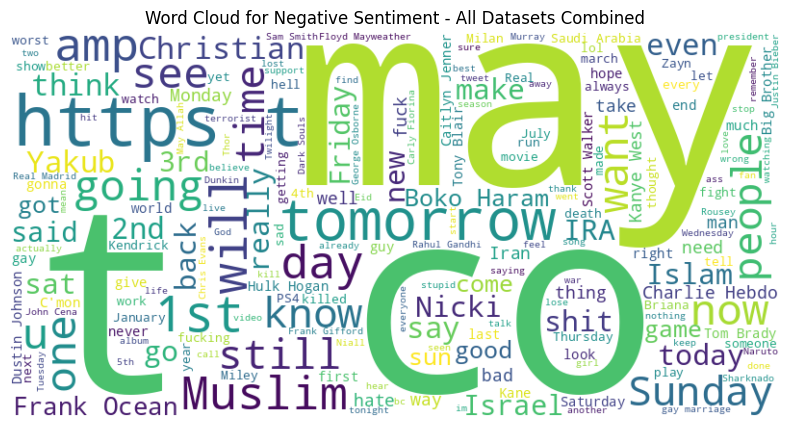

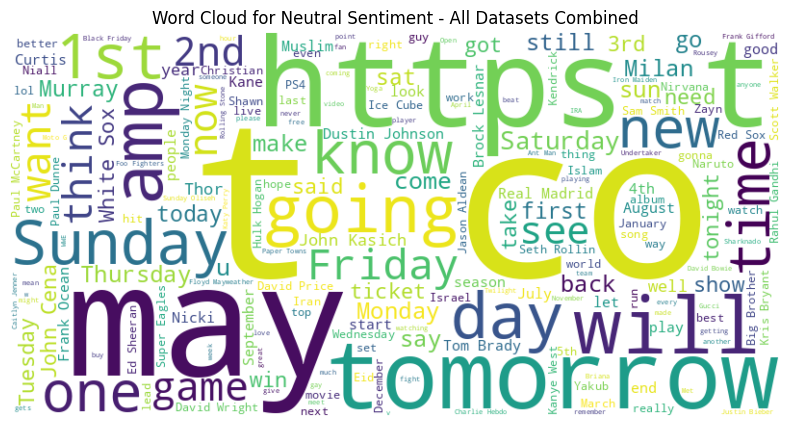

In [ ]:
from wordcloud import WordCloud

def generate_wordcloud_for_sentiment(df, sentiment):
    sentiment_df = df[df['sentiment'] == sentiment]
    all_words = ' '.join(sentiment_df['text'])
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(all_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {sentiment.capitalize()} Sentiment - All Datasets Combined')
    plt.axis('off')
    plt.show()

# Generate word cloud for each sentiment category across all datasets combined
for sentiment in top_unique_words_by_sentiment_combined.keys():
    generate_wordcloud_for_sentiment(combined_df, sentiment)

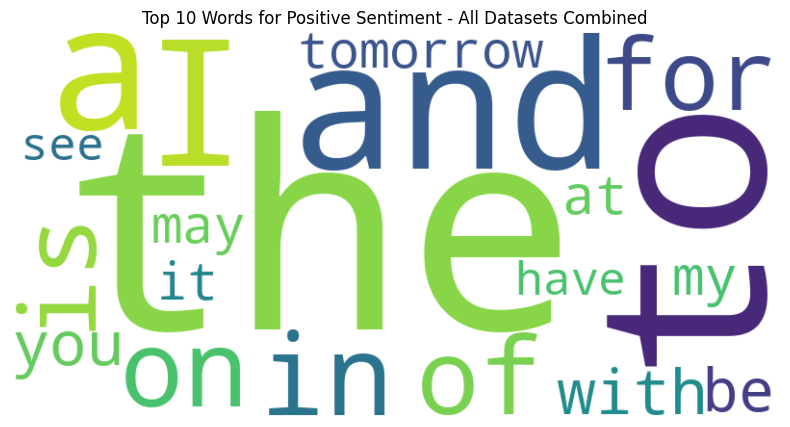

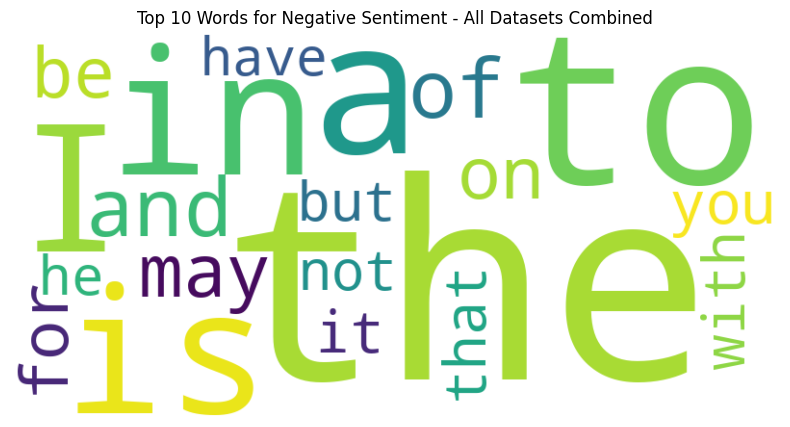

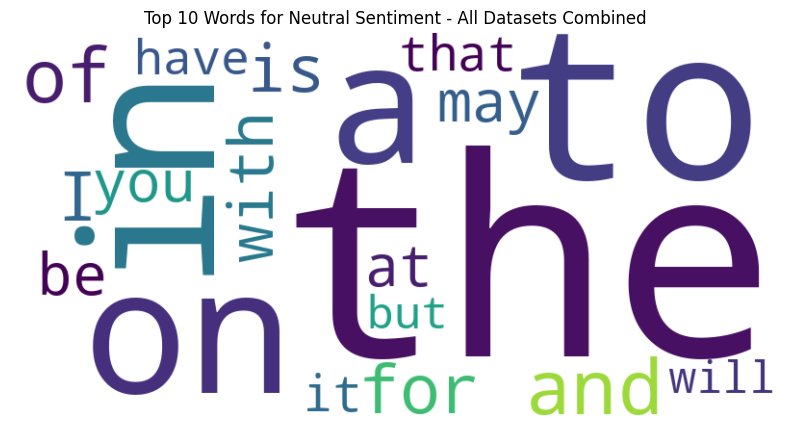

In [ ]:
def generate_wordcloud_top10_for_sentiment(df, sentiment):
    sentiment_df = df[df['sentiment'] == sentiment]
    all_words = ' '.join(sentiment_df['text'])
    # Count the occurrences of each word
    word_counts = Counter(all_words.split())
    # Select the top 10 most frequent words
    top_10_words = dict(word_counts.most_common(20))
    # Generate word cloud using only the top 10 words
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(top_10_words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Top 10 Words for {sentiment.capitalize()} Sentiment - All Datasets Combined')
    plt.axis('off')
    plt.show()

# Generate word cloud for each sentiment category across all datasets combined
for sentiment in top_unique_words_by_sentiment_combined.keys():
    generate_wordcloud_top10_for_sentiment(combined_df, sentiment)

## Modelling

### Modelling with golden data set

### Support Vector Machine:
The majority of classification problems can be boiled down to the problem statement: Given n features and therefore n-dimensional data we want to predict and label out of N categories. To solve such a problem we can use Support Vector Machines (SVMs), aim to find the optimal hyperplane that separates different classes in a dataset while maximizing the distance between the hyperplane and the nearest data points of each class, called support vectors. SVMs are effective for both linearly separable and non-linearly separable data through the use of kernel functions, which implicitly map the input data into higher-dimensional space.

Linear Support Vector Classification (LinearSVC) is a specific implementation of SVMs designed for linearly separable datasets. It aims to find the optimal linear hyperplane that separates different classes in the feature space, maximizing the margin between classes. We can define this in a mathematical manner as seen below.

Given a training dataset $ ( \mathbf{X}, \mathbf{y})$, where $\mathbf{X} = (x)_{i=0}^{n}$ represents the input feature vectors and $\mathbf{y} = (y_{i})_{i=0}^{n}$ represents the corresponding class labels. The goal is to find the optimal hyperplane defined by $\mathbf{w} \cdot \mathbf{x} + b = 0$ that separates the data points into different classes, where $\mathbf{w}$ is the weight vector orhtogonal to the hyperplane and $b$ being  the bias term. The function we base our categorization on for LinearSVC is therefore $f(\mathbf{x}) = \text{sign}(\mathbf{w} \cdot \mathbf{x} + b)$, rendering the aforementioned optimization problem being formulated as,

$$
\min_{\mathbf{w}, b} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^{n} \max(0, 1 - y_i(\mathbf{w} \cdot \mathbf{x}_i + b))
$$

where $| \text{ }|$ is the Euclidean norm, $C$ is the regularization parameter that regulates the trade-off between maximizing the margin and minimizing the classification error. The optimization problem is therefore to minimize the norm of the weight vector subject to the constraint that each data point lies on the correct side of the decision boundary with a margin of at least 1. The term $C \sum_{i=1}^{n} \max(0, 1 - y_i(\mathbf{w} \cdot \mathbf{x}_i + b))$ penalizes misclassifications, called the hinge loss.

#### Note on the Class_Weight Hyperparamter


### Naïve Bayes & The Multinomial Model


#### Bayes Background

Before diving into the models and their comparisons, one should first be provided with the background of the models and the mathematical foundation the models are built upon. The models that are used in Naïve Bayes is derived from the from Bayes formula,

$$
P(A|B) = \frac{P(B|A)P(A)}{P(B)}
$$

where A and B are events, $P(A|B)$ being the probability of event A occurring given that event B occurred. One can use this formula for a multidimensional (multivariate) situation,

$$
P(C_{k}|\mathbf{x}) = \frac{P(C_{k}|\mathbf{x})P(\mathbf{x})}{P(\mathbf{x}}.
$$

where is $\mathbf{x} = (x_{0},...,x_{k})$, i.e. the text data and $C_{k}$ being the label spam or non-spam. The above can further be rewritten as a joint probability,

$$
P(C_{k}|\mathbf{x}) = \frac{P(C_{k},x_{1},...,x_{k})}{p(\mathbf{x})}.
$$

From the assumption that each text is independent from each other one can write,

$$
P(x_{i}|x_{i+1},...,x_{n},C_{k}) = P(x_{i}|C_{k}).
$$

All of the above can now be used to write the full bayes model,

$$
\begin{split}
P(C_{k}|x_{1},...,x_{n}) &\propto P(x_{i}|x_{i+1},...,x_{n},C_{k})  \\ 
&\propto P(C_{k})P((x_{1}|C_{k})P(x_{2}|C_{k})*...*P(x_{n}|C_{k})  \\
&\propto P(C_{k})\prod_{i=1}^{n}P(x_{i}|C_{k}).
\end{split}
$$

with $\propto$ denoting proportionality.

### Multinomial Model
Now that the mathematical foundation for the Naïve Bayes models has been established, one can now consider the first model, MultinomialNB. 
<br>
As the statistical setting is Bayesian, where prior knowledge of the situation is used, one can assume the priors to be the probability of being a certain certain sentiment. 

Now using the count vectorization process, one can find the conditional probabilities of being a certain class, given a certain word. In this setting the given in the conditional probabilities are the labels. An example of this could be $P(happy|positive)$. These individual probabilities for each word is computed by taking the number of occurrences for that particular word divided by the total amount word in whole. This process is computed for all words for all combinations. 
<br>
To further compute the probability of being two words together and being a certain outcome, on computes by multiplying the prior with each individual conditional probability for every word included. The probabilities similar to the previous given example is considered a proportional score to the probability P(positive|"happy win"). The probability in this example is then computed for all labels. Then the probability that is larger than the other is the predicted label for the given words. 
<br>
From the above one can observe that in some cases, mostly extreme cases, the count of the word hello may have the value 0. This causes problems when computing the probability as previously stated. To fix this one can use the alpha smoothing parameter. The alpha smoothing parameter adds an integer say 1 to all of the counts across all label counts. This results in multiplication with non-zero counts, which therefore elimates the risk of a resulting probability of being 0. One should however note that the higher the alpha smoothing parameter, the less distinct the count value become. This meaning that distinct words that provides information to the decision process will be less important for higher smoothing alphas.
<br>
The Multinomial Naïve Bayes model is applied to discrete data. In this case the data is discrete with occurrence of the words being frequencies. This meaning that the count of each word is used to predict a label or class. 

### Bernoulli Model

The other alternative to a multivariate Multinomial model is the multivariate Bernoulli Naïve Bayes model. This model creates and indicator of each word of the vocabulary. This meaning that the values are either 1 for the words in the vocabulary being present in the text ,or 0 for non-presence.
<br>
The problems that can occur from using this approach is that, compared to the multinomial model, the binomial model does not consider the frequency of a certain word and equally weights the words, no matter the frequency. This can result in the model predicting that a text is of a certian sentiment due to one word being present, which is not telling of the entirety of the text/tweet.  
<br>
In comparison to the multinomial model, the binomial model also takes in explicitly the non-occurrence of words. This is however not done in the multinomial model. One should also note that the models do however have the same time complexity. The difference in models can further be shown by,
<br>
#### Multinomial
$$
\begin{split}
    P(d|c) = P(\langle t_{1},...,t_{n}\rangle | c) = \prod_{1\leq k \leq n_{d}} P(X_{k}=t_{k}|C).
\end{split}
$$


#### Binomial 
$$
\begin{split}
     P(d|c) = P(\langle e_{1},...,e_{M}\rangle | c) = \prod_{1\leq k \leq M} P(U_{i}=e_{i}|C).
\end{split}
$$

From the above one can observe that there are two different random variables, $U$ and $X$. This is to enlighten the differences between the two models. The probability $P(X_{k}=t|C)$ denotes, in the document c the probability of the term t occurring in position k. If one was to observe $U_{i}$ and the probability $P(U_{i}=1|C)$ denotes the probability of the words t will occur anywhere in the document c. This is due to the random variable $U_{i}$ having the possible values 1 or 0. Due to as stated in the section on the mathematical background on Naïve Bayes, the positional independence further simplifies the probabilities above.

Given the above we can hypothesize that the Binomial model will not perform as well as the Multinomial model. Thus arriving at the main question being: LinearSVC or MultinomialNB?

## LinearSVC with Cleaned Gold Train Data

In [ ]:


X_train = gold_train_df['cleaned_text']
y_train = gold_train_df['sentiment']

X_test = test_df['cleaned_text']
y_test = test_df['sentiment']

# Count Vectorizer
clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

# TF-IDF Transformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

# Naive Bayes classifier
nb_clf = LinearSVC(class_weight = 'balanced')

# Fitting the classifier
nb_clf.fit(X_train_tf, y_train)

# Predictions
nb_pred = nb_clf.predict(X_test_tf)

# Printing classification report
print('\tClassification Report for Linear SVC:\n\n', classification_report(y_test, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Linear SVC:

               precision    recall  f1-score   support

    Negative       0.75      0.75      0.75      1077
     Neutral       0.80      0.80      0.80      2597
    Positive       0.79      0.79      0.79      1850

    accuracy                           0.79      5524
   macro avg       0.78      0.78      0.78      5524
weighted avg       0.79      0.79      0.79      5524



Confusion Matrix:
	Classification Report for LinearSVC:

               precision    recall  f1-score   support

    Negative       0.75      0.75      0.75      1077
     Neutral       0.80      0.80      0.80      2597
    Positive       0.79      0.79      0.79      1850

    accuracy                           0.79      5524
   macro avg       0.78      0.78      0.78      5524
weighted avg       0.79      0.79      0.79      5524



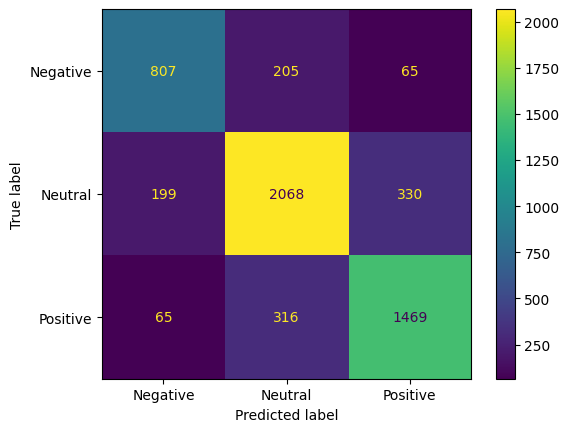

In [ ]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()
# Printing classification report
print('\tClassification Report for LinearSVC:\n\n', classification_report(y_test, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))


## Multinomial Model with Cleaned Gold Train Data

In [ ]:


X_train = gold_train_df['cleaned_text']
y_train = gold_train_df['sentiment']

X_test = test_df['cleaned_text']
y_test = test_df['sentiment']

clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

nb_clf = MultinomialNB()

nb_clf.fit(X_train_tf, y_train)

nb_pred = nb_clf.predict(X_test_tf)

Confusion Matrix:
	Classification Report for Multinomial Naive Bayes:

               precision    recall  f1-score   support

    Negative       0.99      0.08      0.15      1077
     Neutral       0.58      0.94      0.72      2597
    Positive       0.83      0.54      0.65      1850

    accuracy                           0.64      5524
   macro avg       0.80      0.52      0.51      5524
weighted avg       0.74      0.64      0.59      5524



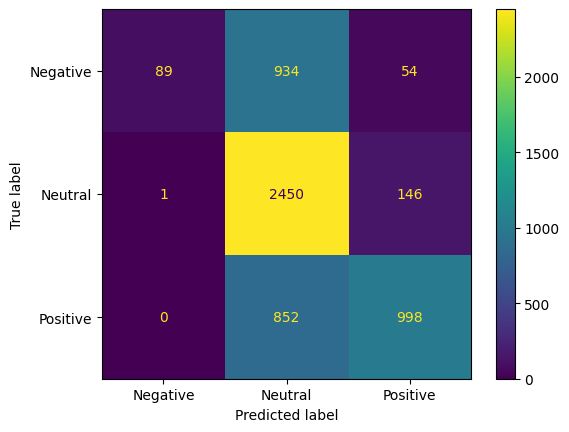

In [ ]:

print("Confusion Matrix:")
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()

# Printing classification report
print('\tClassification Report for Multinomial Naive Bayes:\n\n', classification_report(y_test, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))


### Modelling LinearSVC with Crowdsourced Train Data

In [ ]:


X_train = crowdsourced_train_df['cleaned_text']
y_train = crowdsourced_train_df['sentiment']

X_test = test_df['cleaned_text']
y_test = test_df['sentiment']


clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

# TF-IDF Transformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

# Naive Bayes classifier
nb_clf = LinearSVC()

# Fitting the classifier
nb_clf.fit(X_train_tf, y_train)

# Predictions
nb_pred = nb_clf.predict(X_test_tf)

# Printing classification report
print('\tClassification Report for Linear SVC:\n\n', classification_report(y_test, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Linear SVC:

               precision    recall  f1-score   support

    Negative       0.53      0.56      0.55      1077
     Neutral       0.62      0.69      0.65      2597
    Positive       0.67      0.55      0.60      1850

    accuracy                           0.62      5524
   macro avg       0.61      0.60      0.60      5524
weighted avg       0.62      0.62      0.62      5524



Confusion Matrix:
	Classification Report for LinearSVC:

               precision    recall  f1-score   support

    Negative       0.53      0.56      0.55      1077
     Neutral       0.62      0.69      0.65      2597
    Positive       0.67      0.55      0.60      1850

    accuracy                           0.62      5524
   macro avg       0.61      0.60      0.60      5524
weighted avg       0.62      0.62      0.62      5524



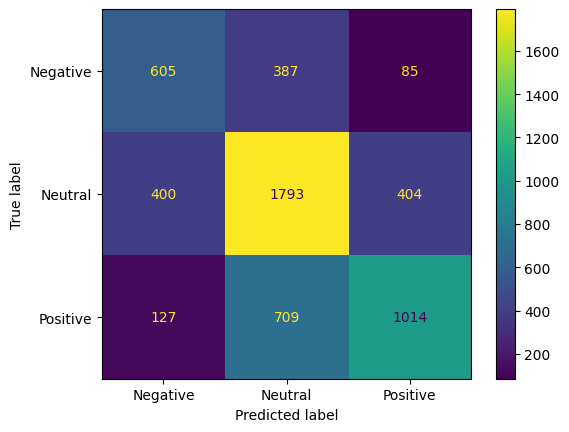

In [ ]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()
# Printing classification report
print('\tClassification Report for LinearSVC:\n\n', classification_report(y_test, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))


In [ ]:
feature_importances = nb_clf.coef_[1]

feature_names = clf.get_feature_names_out()
features_and_importances = list(zip(feature_names, feature_importances))
features_and_importances.sort(key=lambda x: abs(x[1]), reverse=True)

top_n = 20
print(f"Top {top_n} features and their importances:")
for feature, importance in features_and_importances[:top_n]:
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Top 20 features and their importances:
Feature: happy, Importance: -2.7187
Feature: proud, Importance: -2.2053
Feature: excited, Importance: -2.1883
Feature: fucking, Importance: -2.1348
Feature: ridiculous, Importance: -1.9032
Feature: wow, Importance: -1.7759
Feature: upset, Importance: -1.6938
Feature: legend, Importance: -1.6869
Feature: incredible, Importance: -1.6687
Feature: package, Importance: 1.6655
Feature: amazing, Importance: -1.6602
Feature: worse, Importance: -1.6457
Feature: sad, Importance: -1.6223
Feature: best, Importance: -1.6077
Feature: favorite, Importance: -1.5999
Feature: asked, Importance: 1.5961
Feature: irish, Importance: -1.5939
Feature: caught, Importance: 1.5761
Feature: good, Importance: -1.5736
Feature: fuck, Importance: -1.5639


## Modelling Multinomial with Crowdsouced Train Data

In [ ]:
X_train = crowdsourced_train_df['cleaned_text']
y_train = crowdsourced_train_df['sentiment']

X_test = test_df['cleaned_text']
y_test = test_df['sentiment']

# Count Vectorizer
clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

# TF-IDF Transformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

# Naive Bayes classifier
nb_clf = LinearSVC()

# Fitting the classifier
nb_clf.fit(X_train_tf, y_train)

# Predictions
nb_pred = nb_clf.predict(X_test_tf)

# Printing classification report
print('\tClassification Report for Linear SVC:\n\n', classification_report(y_test, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Linear SVC:

               precision    recall  f1-score   support

    Negative       0.53      0.56      0.55      1077
     Neutral       0.62      0.69      0.65      2597
    Positive       0.67      0.55      0.60      1850

    accuracy                           0.62      5524
   macro avg       0.61      0.60      0.60      5524
weighted avg       0.62      0.62      0.62      5524



Confusion Matrix:
	Classification Report for LinearSVC:

               precision    recall  f1-score   support

    Negative       0.53      0.56      0.55      1077
     Neutral       0.62      0.69      0.65      2597
    Positive       0.67      0.55      0.60      1850

    accuracy                           0.62      5524
   macro avg       0.61      0.60      0.60      5524
weighted avg       0.62      0.62      0.62      5524



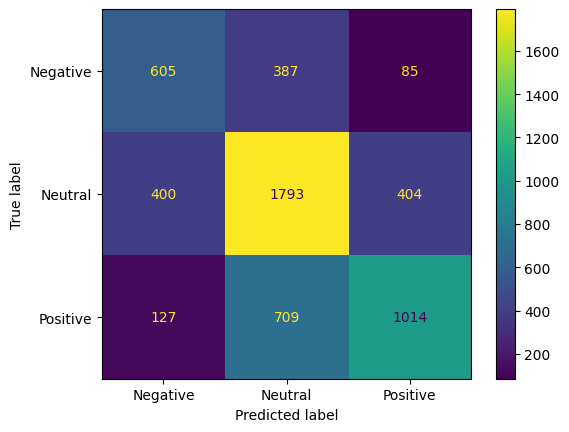

In [ ]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, nb_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()
# Printing classification report
print('\tClassification Report for LinearSVC:\n\n', classification_report(y_test, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))


### Oversampling

In [ ]:
from sklearn.utils import resample

# Perform oversampling for crowdsourced_train_df
# Separate classes
positive_class = crowdsourced_train_df[crowdsourced_train_df['sentiment'] == 'positive']
neutral_class = crowdsourced_train_df[crowdsourced_train_df['sentiment'] == 'neutral']
negative_class = crowdsourced_train_df[crowdsourced_train_df['sentiment'] == 'negative']

# Determine the size of the majority class
majority_size = max(len(positive_class), len(neutral_class), len(negative_class))

# Upsample minority classes
positive_class_upsampled = resample(positive_class, 
                                   replace=True,     # sample with replacement
                                   n_samples=majority_size,    # to match majority class
                                   random_state=42)  # reproducible results

neutral_class_upsampled = resample(neutral_class, 
                                   replace=True,     # sample with replacement
                                   n_samples=majority_size,    # to match majority class
                                   random_state=42)  # reproducible results

negative_class_upsampled = resample(negative_class, 
                                   replace=True,     # sample with replacement
                                   n_samples=majority_size,    # to match majority class
                                   random_state=42)  # reproducible results

# Combine majority class with upsampled minority classes
oversampled_crowdsourced_train_df = pd.concat([positive_class_upsampled, neutral_class_upsampled, negative_class_upsampled])

# Perform oversampling for gold_train_df
# Separate classes
positive_class = gold_train_df[gold_train_df['sentiment'] == 'positive']
neutral_class = gold_train_df[gold_train_df['sentiment'] == 'neutral']
negative_class = gold_train_df[gold_train_df['sentiment'] == 'negative']

# Determine the size of the majority class
majority_size = max(len(positive_class), len(neutral_class), len(negative_class))

# Upsample minority classes
positive_class_upsampled = resample(positive_class, 
                                   replace=True,     # sample with replacement
                                   n_samples=majority_size,    # to match majority class
                                   random_state=42)  # reproducible results

neutral_class_upsampled = resample(neutral_class, 
                                   replace=True,     # sample with replacement
                                   n_samples=majority_size,    # to match majority class
                                   random_state=42)  # reproducible results

negative_class_upsampled = resample(negative_class, 
                                   replace=True,     # sample with replacement
                                   n_samples=majority_size,    # to match majority class
                                   random_state=42)  # reproducible results

# Combine majority class with upsampled minority classes
oversampled_gold_train_df = pd.concat([positive_class_upsampled, neutral_class_upsampled, negative_class_upsampled])


In [ ]:
temp_crowd = oversampled_crowdsourced_train_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp_gold = oversampled_gold_train_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp_test = test_df.groupby('sentiment').count()['text'].reset_index().sort_values(by='text', ascending = False)

In [ ]:
fig = go.Figure(go.Funnelarea(
    text =temp_crowd.sentiment,
    values = temp_crowd.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

We can see from the figure above how the distribution of the labels is now equal and no label count has decreased. This meaning that we have only increased the amount of the labels via oversampling.

In [ ]:
X_train = oversampled_gold_train_df['cleaned_text'].values
y_train = oversampled_gold_train_df['sentiment'].values
X_test = test_df['cleaned_text'].values
y_test = test_df['sentiment'].values


In [ ]:

# Count Vectorizer
clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

# TF-IDF Transformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

# Naive Bayes classifier
nb_clf = LinearSVC()

# Fitting the classifier
nb_clf.fit(X_train_tf, y_train)

# Predictions
nb_pred = nb_clf.predict(X_test_tf)

# Printing classification report
print('\tClassification Report for Linear SVC:\n\n', classification_report(y_test, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Linear SVC:

               precision    recall  f1-score   support

    Negative       0.61      0.79      0.69      1077
     Neutral       0.76      0.66      0.71      2597
    Positive       0.72      0.74      0.73      1850

    accuracy                           0.71      5524
   macro avg       0.70      0.73      0.71      5524
weighted avg       0.72      0.71      0.71      5524



We can see that when we use oversampled data on final model, we level out the recall. This case exemplifies how sampling techniques also have issues within themselves. This means that solving a sampling problems comes with problems. The issue we see here is that while we have leveled out the recall and f1-score, the scores are in fact worse than the non-oversampled data. This means that oversampling is not the way to go. We could look at other ways to perform such sampling: Stratifying, undersampling etc.

In [ ]:

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X_train = oversampled_gold_train_df['cleaned_text']
y_train = oversampled_gold_train_df['sentiment']

X_test = test_df['cleaned_text']
y_test = test_df['sentiment']



# Count Vectorizer
clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

# TF-IDF Transformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

# Naive Bayes classifier
nb_clf = MultinomialNB()

# Fitting the classifier
nb_clf.fit(X_train_tf, y_train_le)

# Predictions
nb_pred = nb_clf.predict(X_test_tf)

# Printing classification report
print('\tClassification Report for Multinomial:\n\n', classification_report(y_test, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))

	Classification Report for Linear SVC:

               precision    recall  f1-score   support

    Negative       0.51      0.81      0.63      1077
     Neutral       0.77      0.48      0.59      2597
    Positive       0.64      0.77      0.70      1850

    accuracy                           0.64      5524
   macro avg       0.64      0.69      0.64      5524
weighted avg       0.68      0.64      0.64      5524



# Analyzing the final model

## Gold Train Data

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

X_train = gold_train_df['cleaned_text']
y_train = gold_train_df['sentiment']

X_test = test_df['cleaned_text']
y_test = test_df['sentiment']

# Count Vectorizer
clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

# TF-IDF Transformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

# Naive Bayes classifier
nb_clf = LinearSVC(class_weight = 'balanced')

# Fitting the classifier
nb_clf.fit(X_train_tf, y_train)

# Predictions
nb_pred = nb_clf.predict(X_test_tf)


Confusion Matrix:
	Classification Report for LinearSVC:

               precision    recall  f1-score   support

    Negative       0.75      0.75      0.75      1077
     Neutral       0.80      0.80      0.80      2597
    Positive       0.79      0.79      0.79      1850

    accuracy                           0.79      5524
   macro avg       0.78      0.78      0.78      5524
weighted avg       0.79      0.79      0.79      5524



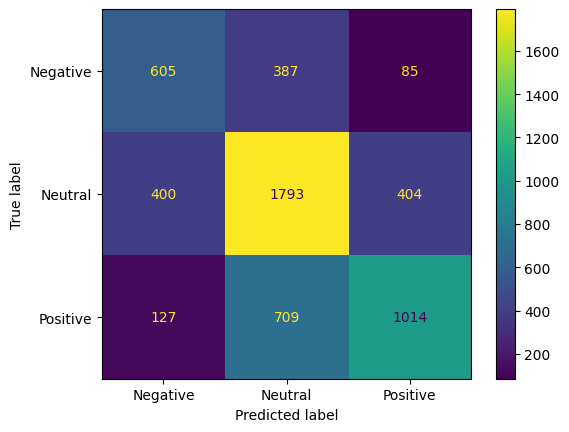

In [ ]:
print("Confusion Matrix:")
cm = confusion_matrix(y_test, nb_pred)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()
# Printing classification report
print('\tClassification Report for LinearSVC:\n\n', classification_report(y_test, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))


In [ ]:
feature_importances_golden = {'negative': nb_clf.coef_[0],'neutral': nb_clf.coef_[1],'positive': nb_clf.coef_[2]}

feature_names = clf.get_feature_names_out()
features_and_importances = list(zip(feature_names, feature_importances))
features_and_importances.sort(key=lambda x: abs(x[1]), reverse=True)

top_n = 20
print(f"Top {top_n} features and their importances:")
for feature, importance in features_and_importances[:top_n]:
    print(f"Feature: {feature}, Importance: {importance:.4f}")

Top 20 features and their importances:
Feature: happing, Importance: -2.7187
Feature: prototype, Importance: -2.2053
Feature: excited, Importance: -2.1883
Feature: fucking, Importance: -2.1348
Feature: rides, Importance: -1.9032
Feature: wounds, Importance: -1.7759
Feature: ups, Importance: -1.6938
Feature: legandx, Importance: -1.6869
Feature: increasingly, Importance: -1.6687
Feature: pacific, Importance: 1.6655
Feature: amazing, Importance: -1.6602
Feature: worry, Importance: -1.6457
Feature: sacrificing, Importance: -1.6223
Feature: best, Importance: -1.6077
Feature: favorite, Importance: -1.5999
Feature: asked, Importance: 1.5961
Feature: irelands, Importance: -1.5939
Feature: caught, Importance: 1.5761
Feature: goo, Importance: -1.5736
Feature: fuck, Importance: -1.5639


## Crowdsourced Train

In [ ]:

X_train = crowdsourced_train_df['cleaned_text']
y_train = crowdsourced_train_df['sentiment']

X_test = test_df['cleaned_text']
y_test = test_df['sentiment']


# Count Vectorizer
clf = CountVectorizer()
X_train_cv = clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

# TF-IDF Transformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

# Naive Bayes classifier
nb_clf = LinearSVC()

# Fitting the classifier
nb_clf.fit(X_train_tf, y_train)

# Predictions
nb_pred = nb_clf.predict(X_test_tf)

Confusion Matrix:
	Classification Report for LinearSVC:

               precision    recall  f1-score   support

    Negative       0.53      0.56      0.55      1077
     Neutral       0.62      0.69      0.65      2597
    Positive       0.67      0.55      0.60      1850

    accuracy                           0.62      5524
   macro avg       0.61      0.60      0.60      5524
weighted avg       0.62      0.62      0.62      5524



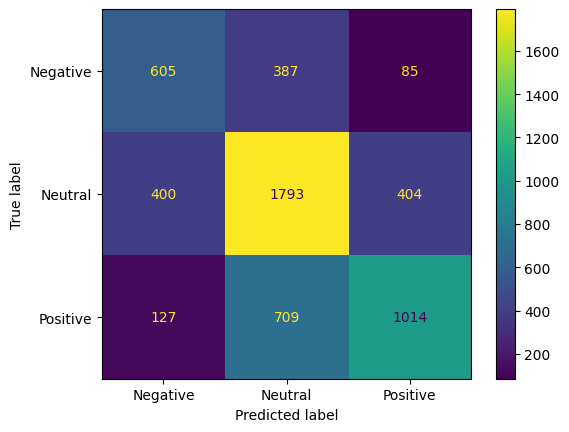

In [ ]:
print("Confusion Matrix:")
cm2 = confusion_matrix(y_test, nb_pred)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=['Negative', 'Neutral', 'Positive'])
disp.plot()
# Printing classification report
print('\tClassification Report for LinearSVC:\n\n', classification_report(y_test, nb_pred, target_names=['Negative', 'Neutral', 'Positive']))


In [ ]:
feature_importances_crowd  = {'negative': nb_clf.coef_[0],'neutral': nb_clf.coef_[1],'positive': nb_clf.coef_[2]}


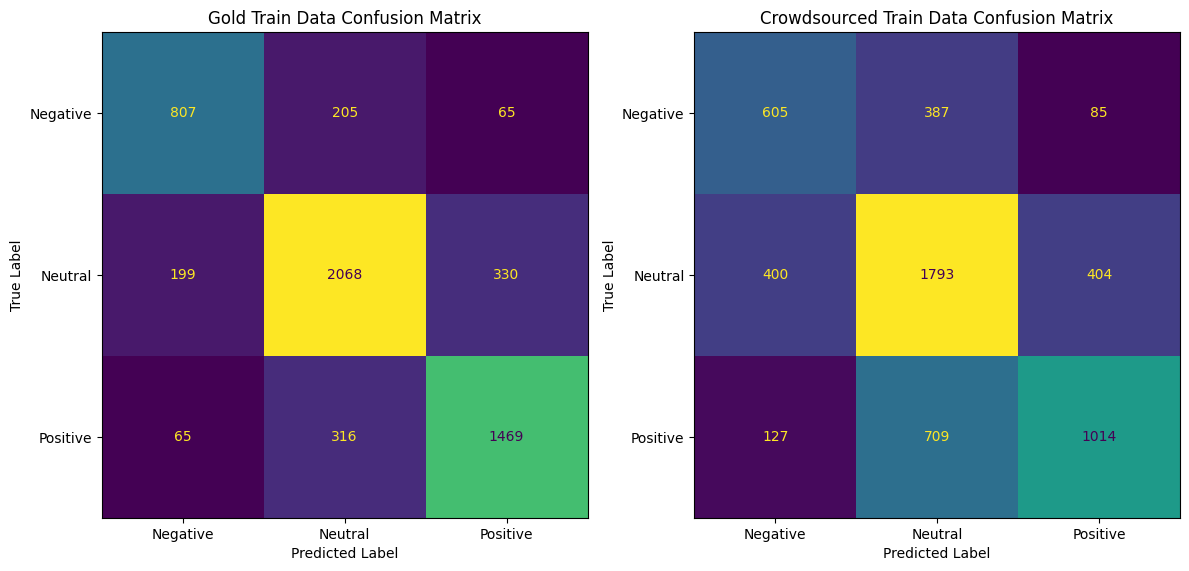

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

disp1.plot(ax=axes[0], values_format='d', colorbar=False)
axes[0].set_title('Gold Train Data Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

disp2.plot(ax=axes[1], values_format='d', colorbar = False)
axes[1].set_title('Crowdsourced Train Data Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

### Analyzing the matrices

We can see that there a a lot of predicted positive labels that are in fact neutral or vice versa. This seems reasonable given the discussion about the label imbalance and bias. We can also note that certain words may be considered to be informative for multiple sentiments. Such words can misguide the model and it's predictions. 

In a confusion matrix, we want the majority of the values to be in a diagonal line from the upper left corner to the lower right corner. We can see that the confusion matrix for the golden data, as seen in the figure above, has an overall better recall than the confusion matrix to the righ, which depicts the results for the crowdsourced train data. For example, in 709 cases, a text was predicted to be neutral while it was actually positive. This difference makes sense, as we found that the accuracy and f1-score of the crowdsourced train data was lower than that of the gold train data.

There could be various reasons as to why a ML model mislabels pieces of text. Firstly, a ML algorithm will have more difficulty labelling text when the data we fit the model on shares a substantial amount of information between the labels. Further, a problem that we ran into in this specific dataset is the underrepresentation of certain labels within the training dataset. Due to this, a ML model might not be able to recognize the pattern for that specific label, due to which the ML model is less likely to recognize it and classify it properly.

Another explanation could be that there is too much noise in the training data set. Noise will disrupt the models ability to find patterns within the training dataset.


### Extracting feature importances

We can further analyze the model by looking at the feature importances, and to see if there are any words that seem to be either in more than one sentiment or part of one sentiment but doesn't fit. 

In [ ]:
def print_feature_importances(feature_importances, title):
    for sentiment, importance in feature_importances.items():
        sorted_features = sorted(zip(clf.get_feature_names_out(), importance), key=lambda x: abs(x[1]), reverse=True)
        df = pd.DataFrame(sorted_features[:20], columns=['Feature', 'Importance'])
        # Print sentiment title
        print(f"\n{title} - {sentiment.capitalize()} Sentiment:")
        # Print dataframe
        print(df.to_string(index=False))

# Print feature importances for crowdsourced data
print_feature_importances(feature_importances_crowd, "Crowdsourced Data")


Crowdsourced Data - Negative Sentiment:
     Feature  Importance
       worst    2.951039
         sad    2.560745
       upset    2.363684
      stupid    2.049495
  ridiculous    2.008574
      racist    2.006488
       trash    1.969738
    pathetic    1.937718
     jealous    1.932801
        hate    1.926896
       worse    1.873850
       idiot    1.848558
       bitch    1.843346
        ugly    1.818774
        shit    1.803012
disappointed    1.788755
        fuck    1.778106
        kill    1.766372
      paying    1.754635
        zero    1.746841

Crowdsourced Data - Neutral Sentiment:
   Feature  Importance
     happy   -2.718744
     proud   -2.205319
   excited   -2.188335
   fucking   -2.134752
ridiculous   -1.903208
       wow   -1.775899
     upset   -1.693789
    legend   -1.686883
incredible   -1.668676
   package    1.665535
   amazing   -1.660147
     worse   -1.645695
       sad   -1.622316
      best   -1.607707
  favorite   -1.599937
     asked    1.596095
   

In [ ]:
# Print feature importances for golden data
print_feature_importances(feature_importances_golden, "Golden Data")


Golden Data - Negative Sentiment:
     Feature  Importance
       worth    3.371236
       paths    2.690291
        fuck    2.653442
  stupidfree    2.499580
     clearly    2.488488
       bitch    2.480730
       ruins    2.462320
     worship    2.393844
        jean    2.264951
      sudden    2.216028
   pistachio    2.190030
      sweats    2.114074
         nay    2.113434
disappointed    2.055746
       hated    2.053704
    saddened    2.037464
         lot    2.029948
    bullshit    2.028798
    horribly    2.014264
    shitfest    1.980474

Golden Data - Neutral Sentiment:
   Feature  Importance
 happydays   -2.901424
   amazing   -2.721235
   greater   -2.608249
   excited   -2.578636
   awesome   -2.312131
     loved   -2.247826
      best   -2.156075
   goodbye   -1.938771
  likegive   -1.820611
  proudmay   -1.806896
   forward   -1.782907
     enjoy   -1.639685
   powered   -1.637453
       woy   -1.614240
suckmynado   -1.597658
 confirmed    1.594625
  welcomes   -1

We can see from the obtained feature importances how the word "happy" is present for all labels. This is an interesting case. When sifting through the crowdsourced data we find that the text "Head coach of the Super Eagles, Sunday Oliseh, has insisted he is happy with one point, after they..." is labelled to be neutral. This is a primary example of how many words in the english vocabulary have different meaning depending on the context. In this case the word "happy" is synonymous with "being content", the feeling is neither good nor bad. In other cases the word happy can be negative or positive. This shows that we might be better off using a vector representation that considers context and semantics. This can be solved by using embeddings.

### What are Embeddings?
Word embeddings provide a representation of words of vectors in a high dimensional vector space. Such representations are found by neural networks that can predict the context given the text/word. In our case we use the Word2Vec network and method.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2969cd51-4297-4989-94de-4d95397c9384' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>